# Vibration-Based Condition Monitoring
## Static Load Analysis — Gearbox & Bearing Fault Diagnostics

**Author:** Bradley Paul Nast  
**Module:** MEV781 — Vibration Based Condition Monitoring  
**University:** University of Pretoria  

---

This notebook covers the full diagnostic pipeline for fault identification in a gearbox operating under **constant shaft speed** (900 RPM). The pipeline moves through three stages:

1. **Signal Decomposition & TSA** — Separating deterministic (gear) and stochastic (bearing/noise) signal components using Time Synchronous Averaging
2. **Spectral Kurtosis & Filtering** — Identifying the optimal frequency band for fault enhancement
3. **Envelope Analysis & SES** — Isolating bearing fault frequencies from the filtered residual signal

The system uses a SKF 6206 bearing. All signal processing functions are custom implementations.

---
## 0. Imports & Configuration

In [ ]:
import numpy as np
import scipy as sp
import scipy.io as sio
from scipy.signal import butter, filtfilt, hilbert
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import urllib.request
import io

# Plot styling
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})

print('Libraries loaded.')

Libraries loaded.


---
## 1. Load Data & System Parameters

In [ ]:
# ── Load .mat file from GitHub ────────────────────────────────────────────────
url = 'https://raw.githubusercontent.com/0xBPNast/data-science-portfolio/main/projects/condition-monitoring/data/mev_a2_q1_data.mat'

with urllib.request.urlopen(url) as response:
    data = sio.loadmat(io.BytesIO(response.read()))

# Extract vibration signal components
x_gearbox = data['x_gearbox'].squeeze()   # Composite gearbox signal (gear + bearing + noise)
x_gear    = data['x_gear'].squeeze()      # Gear vibration component (for validation)
x_bearing = data['x_bearing'].squeeze()   # Bearing vibration component (for validation)
x_noise   = data['x_noise'].squeeze()     # Noise component (for validation)

# Extract tachometer signal and sampling parameters
tacho    = data['tacho_signal'].squeeze()
fs_vib   = data['Fs'].item()              # Vibration sampling frequency [Hz]
fs_tacho = data['Fs_tacho'].item()        # Tachometer sampling frequency [Hz]
PPR      = data['ppr'].item()             # Tachometer pulses per revolution

print(f'Vibration Fs : {fs_vib} Hz')
print(f'Tacho Fs     : {fs_tacho} Hz')
print(f'PPR          : {PPR}')
print(f'Signal length: {len(x_gearbox)} samples ({len(x_gearbox)/fs_vib:.2f} s)')

# ── System parameters — SKF 6206 bearing at 900 RPM ─────────────────────────
RPM     = 900
fr      = RPM / 60                      # Shaft rotational frequency [Hz]
GMF     = fr * 30                       # Gear meshing frequency — 30 gear teeth [Hz]

# Bearing fault frequencies from SKF 6206 calculator [Hz]
BPFO = 53.523                           # Ball Pass Frequency, Outer Race
BPFI = 81.477                           # Ball Pass Frequency, Inner Race
FTF  = 5.947                            # Fundamental Train Frequency
BSF  = 34.67                            # Ball Spin Frequency

print(f'\nShaft frequency    : {fr:.2f} Hz')
print(f'Gear mesh frequency: {GMF:.2f} Hz')
print(f'BPFO               : {BPFO:.3f} Hz')
print(f'BPFI               : {BPFI:.3f} Hz')
print(f'FTF                : {FTF:.3f} Hz')
print(f'BSF                : {BSF:.2f} Hz')

Vibration Fs : 25000 Hz
Tacho Fs     : 45000 Hz
PPR          : 15
Signal length: 100000 samples (4.00 s)

Shaft frequency    : 15.00 Hz
Gear mesh frequency: 450.00 Hz
BPFO               : 53.523 Hz
BPFI               : 81.477 Hz
FTF                : 5.947 Hz
BSF                : 34.67 Hz


---
## Part 1 — Signal Decomposition & Time Synchronous Averaging (TSA)

The composite gearbox signal `x_gearbox` is a superposition of gear vibration, bearing vibration, and broadband noise. Direct frequency analysis of this signal makes it difficult to isolate individual fault frequencies.

**Time Synchronous Averaging (TSA)** resolves this by averaging the signal over many complete shaft revolutions. Deterministic content (gear mesh and harmonics) reinforces through averaging, while stochastic content (bearing impulses and noise) cancels. The residual `x_residual = x_gearbox - x_TSA` then isolates the bearing signal for downstream analysis.

In [10]:
def tsa(tacho, Fs_tacho, signal, Fs_signal, tacho_trigger, tacho_ppr):
    """
    Time Synchronous Averaging (TSA).

    Isolates the deterministic (gear) component of a vibration signal by
    averaging over complete shaft revolutions, synchronised to a tachometer.
    Handles both equal and unequal pulse spacing via interpolation.

    Parameters
    ----------
    tacho         : array — tachometer signal (1D)
    Fs_tacho      : float — tachometer sampling frequency [Hz]
    signal        : array — vibration signal (1D)
    Fs_signal     : float — vibration sampling frequency [Hz]
    tacho_trigger : float — tachometer pulse trigger value
    tacho_ppr     : int   — pulses per revolution

    Returns
    -------
    method    : str   — 'Reinterpolated' or 'Standard'
    x_tsa_nr  : array — TSA signal extended over full signal length
    Ns        : int   — samples per revolution
    Ns_tot    : int   — total samples across all revolutions
    Nr        : int   — number of complete revolutions averaged
    t_tacho   : array — tacho time array
    ind_ppr_tac : array — PPRth tacho pulse indices
    t_signal  : array — vibration signal time array
    ind_ppr_sig : array — PPRth vibration signal indices
    """

    # ── Tachometer signal parameters ─────────────────────────────────────────
    dt_tacho = 1 / Fs_tacho
    N_tacho  = np.size(tacho)
    tf_tacho = dt_tacho * N_tacho
    t_tacho  = np.arange(0, tf_tacho, dt_tacho)

    # Find sample indices where tacho pulse occurs
    ind_tac = np.where(tacho == tacho_trigger)[0]

    # Extract every PPRth pulse index (one per revolution)
    Nr = int(np.floor(len(ind_tac) / tacho_ppr))
    ind_ppr_tac = np.zeros(Nr, dtype=int)

    for i in range(1, Nr + 1):
        ind_ppr_tac[i - 1] = ind_tac[tacho_ppr * i - 1]

    # Get time points at each revolution boundary
    t_tacho_pprs = t_tacho[ind_ppr_tac]

    # ── Vibration signal parameters ───────────────────────────────────────────
    dt_signal = 1 / Fs_signal
    N_signal  = np.size(signal)
    tf_signal = dt_signal * N_signal
    t_signal  = np.arange(0, tf_signal, dt_signal)

    # Correlate tacho revolution times with vibration signal indices
    ind_ppr_sig = np.zeros(len(ind_ppr_tac), dtype=int)

    for i in range(len(t_tacho_pprs)):
        ind_ppr_sig[i] = np.argmin(np.abs(t_signal - t_tacho[ind_ppr_tac[i]]))

    # Check whether sample count between revolutions is uniform
    diff_check = np.diff(ind_ppr_sig)

    # ── Next power of 2 helper ────────────────────────────────────────────────
    def nextpower(value):
        power = 2 ** np.arange(0, 16, 1)
        for p in power:
            if value < p:
                return p

    # ── Case 1: Unequal spacing — resample each revolution to fixed length ────
    if np.mean(diff_check) != 0:

        Ns     = nextpower(diff_check[0])
        Ns_tot = Ns * Nr
        t_ns   = []
        s_ns   = []
        x_tsa  = np.zeros(Ns)

        for i in range(Nr):
            t_start = 0 if i == 0 else t_signal[ind_ppr_sig[i - 1]]
            t_end   = t_signal[ind_ppr_sig[i]]
            t_int   = np.linspace(t_start, t_end, Ns)
            sig_int = np.interp(t_int, t_signal, signal)
            t_ns.append(t_int)
            s_ns.append(sig_int)
            x_tsa += sig_int

        t_ns  = np.array(t_ns).reshape(-1)
        s_ns  = np.array(s_ns).reshape(-1)
        x_tsa = x_tsa / Nr

        # Extend TSA over full signal length
        x_tsa_nr = np.zeros(len(t_ns))
        for i in range(Nr):
            x_tsa_nr[i * Ns:(i + 1) * Ns] = x_tsa

        x_tsa_nr = np.interp(t_signal[:ind_ppr_sig[-1]], t_ns, x_tsa_nr)

        return ('Reinterpolated', x_tsa_nr, Ns, Ns_tot, Nr,
                t_tacho, ind_ppr_tac, t_signal, ind_ppr_sig)

    # ── Case 2: Equal spacing — direct averaging ──────────────────────────────
    else:

        Ns     = diff_check[0]
        Ns_tot = Ns * Nr
        x_tsa  = np.zeros(Ns)

        for i in range(Nr):
            start  = ind_ppr_sig[i]
            x_tsa += signal[start:start + Ns]
            
        x_tsa = x_tsa / Nr

        # Extend TSA over full signal length
        x_tsa_nr = np.zeros(Nr * Ns)

        for i in range(Nr):
            x_tsa_nr[i * Ns:(i + 1) * Ns] = x_tsa

        return ('Standard', x_tsa_nr, Ns, Ns_tot, Nr,
                t_tacho, ind_ppr_tac, t_signal, ind_ppr_sig)

TSA method          : Reinterpolated
Revolutions averaged: 59
Samples per rev     : 2048
TSA signal length   : 98333 samples
Residual length     : 98333 samples


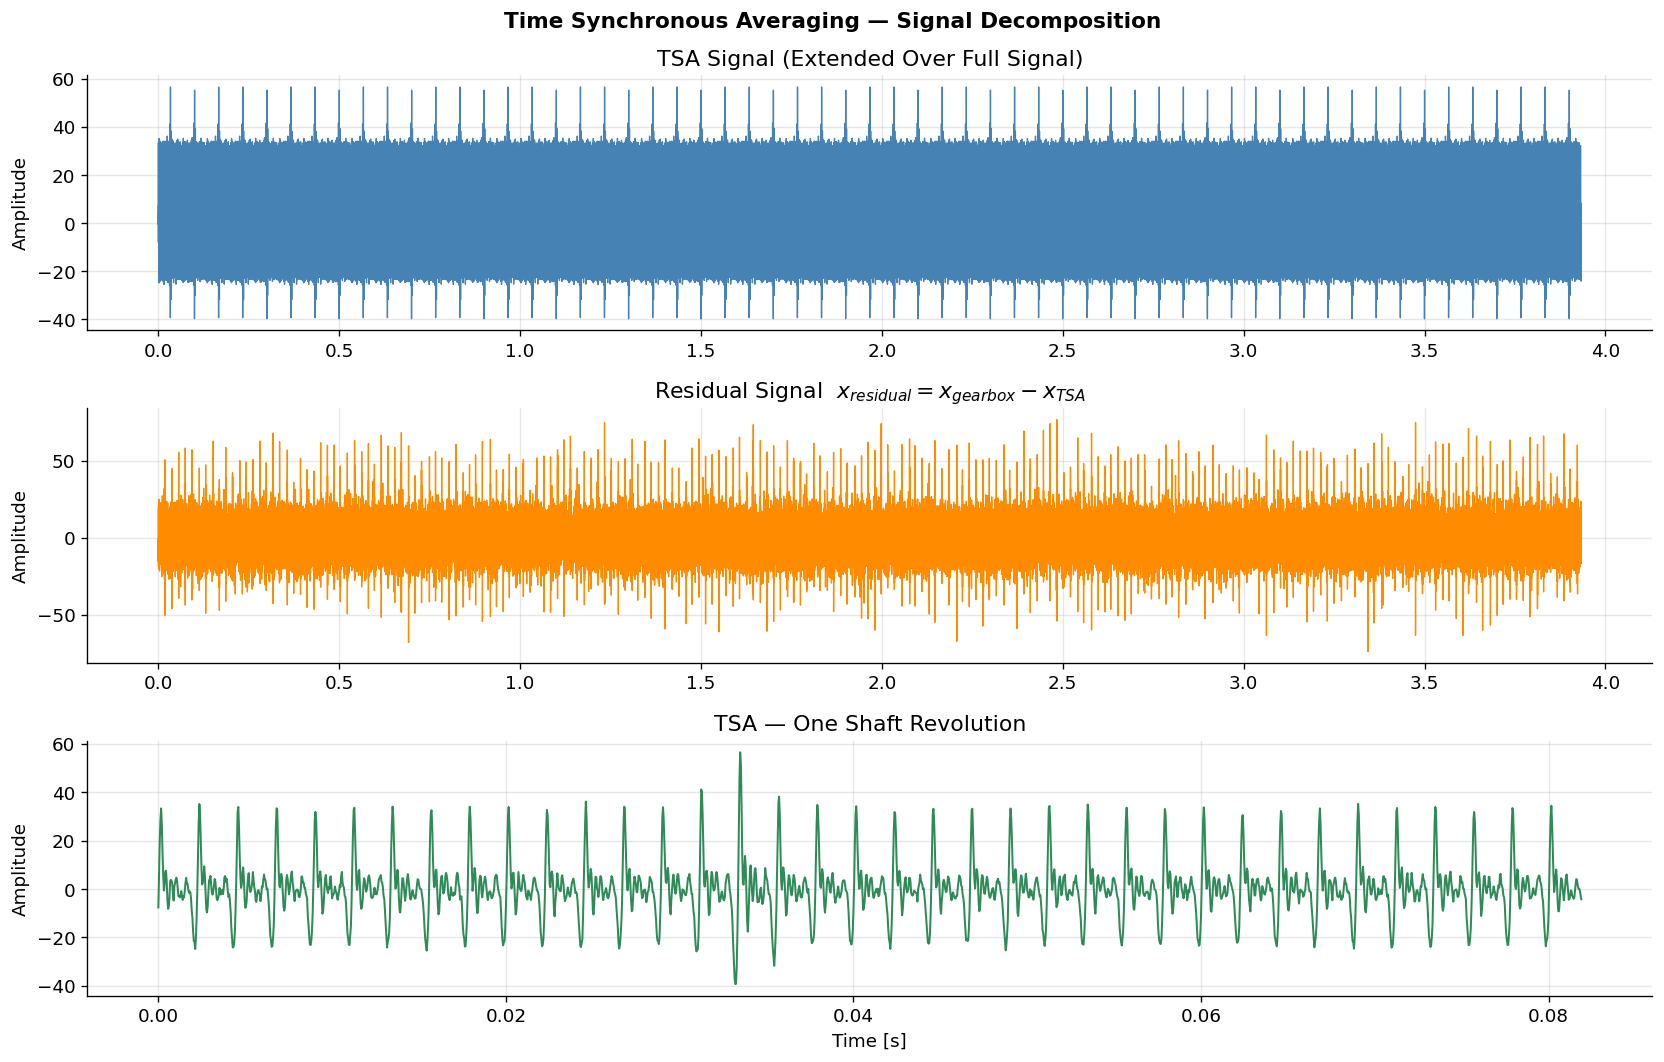

In [11]:
# ── Run TSA ──────────────────────────────────────────────────────────────────
result = tsa(tacho, fs_tacho, x_gearbox, fs_vib,
             tacho_trigger=1, tacho_ppr=PPR)

# Unpack results
method      = result[0]
x_tsa_ext   = result[1]
Ns          = result[2]
Nr          = result[4]
t_signal    = result[7]
ind_ppr_sig = result[8]

# Compute residual signal over the TSA length
x_tsa_one  = x_tsa_ext[:Ns]                        # Single revolution TSA
x_residual = x_gearbox[:len(x_tsa_ext)] - x_tsa_ext

# Time axes
t_vib = np.arange(len(x_gearbox)) / fs_vib
t_tsa = np.arange(Ns) / fs_vib

print(f'TSA method          : {method}')
print(f'Revolutions averaged: {Nr}')
print(f'Samples per rev     : {Ns}')
print(f'TSA signal length   : {len(x_tsa_ext)} samples')
print(f'Residual length     : {len(x_residual)} samples')

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=False)

axes[0].plot(t_vib[:len(x_tsa_ext)], x_tsa_ext, color='steelblue', lw=0.8)
axes[0].set_title('TSA Signal (Extended Over Full Signal)')
axes[0].set_ylabel('Amplitude')

axes[1].plot(t_vib[:len(x_residual)], x_residual, color='darkorange', lw=0.8)
axes[1].set_title(r'Residual Signal  $x_{residual} = x_{gearbox} - x_{TSA}$')
axes[1].set_ylabel('Amplitude')

axes[2].plot(t_tsa, x_tsa_one, color='seagreen', lw=1.2)
axes[2].set_title('TSA — One Shaft Revolution')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time [s]')

plt.suptitle('Time Synchronous Averaging — Signal Decomposition',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### TSA Results

The TSA effectively separates the deterministic gear content from the stochastic bearing and noise components:

- **`x_tsa`** — deterministic gear signal. Each peak corresponds to a gear tooth mesh event. A higher amplitude peak at a specific tooth index is indicative of a localised gear tooth fault (e.g. pitting).
- **`x_residual`** — stochastic component. Periodic impulses at the BPFO period (~0.0187s) correspond to the bearing outer race fault.

The quality of separation improves with the number of complete shaft revolutions available for averaging.

---
## Part 2 — Spectral Kurtosis

The residual signal still contains significant broadband noise. **Spectral Kurtosis (SK)** identifies the frequency band where the signal is most impulsive (highest kurtosis), providing a principled basis for bandpass filter design.

SK is computed via the Short-Time Fourier Transform (STFT) with a Hann window. Window length governs the frequency resolution — too short causes leakage, too long dilutes impulsivity.

In [15]:
def sk(signal, Fs, Nw, No, win_type='hann'):
    """
    Spectral Kurtosis via STFT.

    Computes the kurtosis of each frequency bin across STFT frames to
    identify frequency bands with high impulsivity. Accepts arrays of
    window lengths and overlaps for multi-window comparison.

    Parameters
    ----------
    signal   : array — input signal (1D)
    Fs       : float — sampling frequency [Hz]
    Nw       : array — window length(s) in samples
    No       : array — overlap length(s) in samples (must match length of Nw)
    win_type : str   — window type (default 'hann')

    Returns
    -------
    results : list of tuples — [(freqs, speckurt), ...] for each window length
    """
    results = []

    for n_points, n_over in zip(Nw, No):

        sfreq, _, stft = sp.signal.stft(
            signal, fs=Fs, window=win_type,
            nperseg=n_points, noverlap=n_over,
            return_onesided=True
        )

        speckurt = np.zeros(len(sfreq))
        for j in range(len(sfreq)):
            speckurt[j] = (
                np.mean(np.abs(stft[j, :]) ** 4) /
                np.mean(np.abs(stft[j, :]) ** 2) ** 2
            ) - 2

        results.append((sfreq, speckurt))

    return results

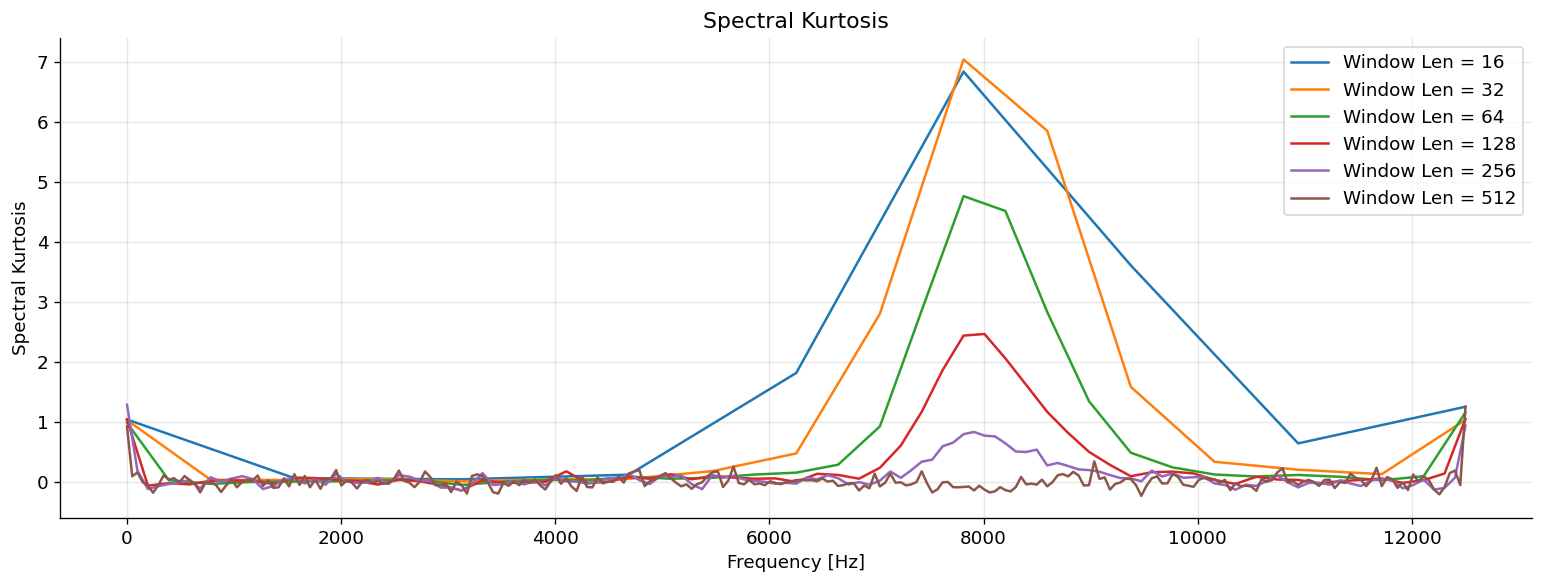

In [16]:
window_lengths = [16, 32, 64, 128, 256, 512]
overlaps       = [w // 2 for w in window_lengths]   # 50% overlap

results = sk(x_residual, fs_vib, window_lengths, overlaps, win_type='hann')

fig, ax = plt.subplots(figsize=(13, 5))
for (freqs, speckurt), w in zip(results, window_lengths):
    ax.plot(freqs, speckurt, label=f'Window Len = {w}')

ax.set_title('Spectral Kurtosis')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Spectral Kurtosis')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

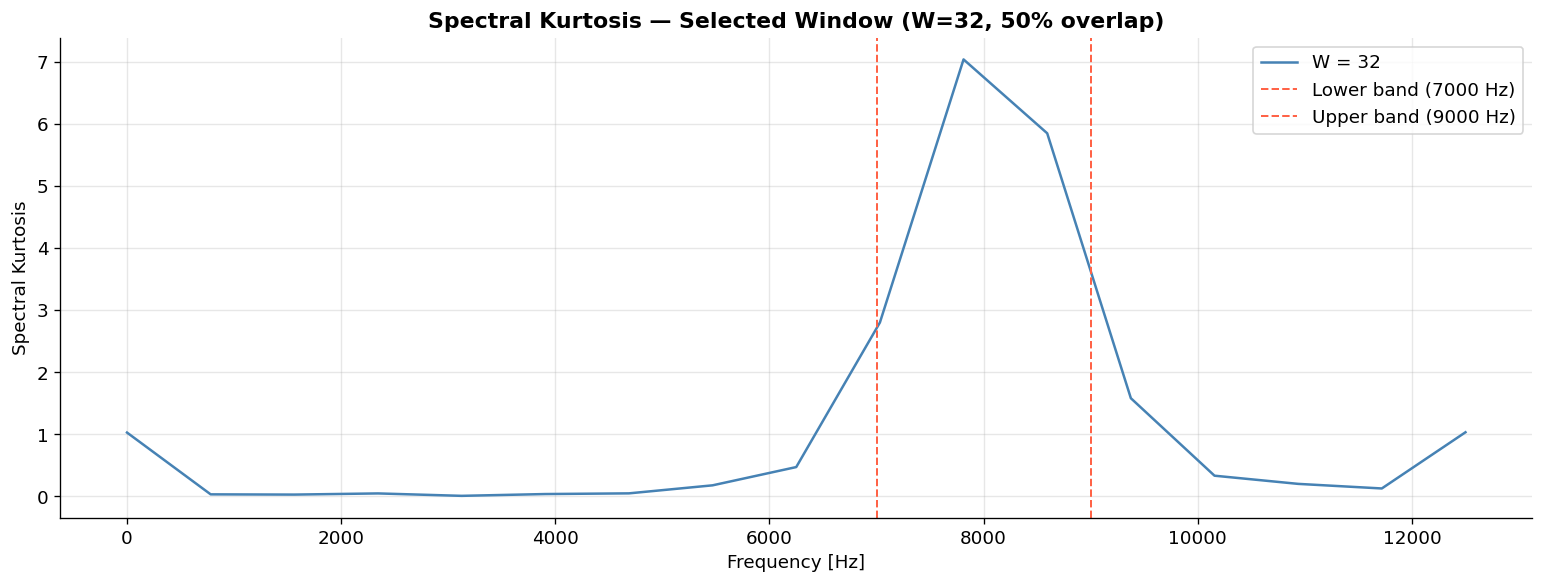

Selected passband: 7000 – 9000 Hz


In [18]:
# ── Select window length and define passband ──────────────────────────────────
SELECTED_WINDOW = 32      # Chosen based on SK peak sharpness — adjust if needed
PASSBAND_LOW    = 7000    # Hz — adjust based on your SK plot
PASSBAND_HIGH   = 9000    # Hz — adjust based on your SK plot

# Run SK for selected window only (50% overlap)
freqs_sel, sk_sel = sk(
    x_residual, fs_vib,
    Nw=[SELECTED_WINDOW],
    No=[SELECTED_WINDOW // 2],
    win_type='hann'
)[0]   # Unpack first (and only) result tuple

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(freqs_sel, sk_sel, color='steelblue', lw=1.5, label=f'W = {SELECTED_WINDOW}')
ax.axvline(PASSBAND_LOW,  color='tomato', ls='--', lw=1.2, label=f'Lower band ({PASSBAND_LOW} Hz)')
ax.axvline(PASSBAND_HIGH, color='tomato', ls='--', lw=1.2, label=f'Upper band ({PASSBAND_HIGH} Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Spectral Kurtosis')
ax.set_title(f'Spectral Kurtosis — Selected Window (W={SELECTED_WINDOW}, 50% overlap)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Selected passband: {PASSBAND_LOW} – {PASSBAND_HIGH} Hz')

### Spectral Kurtosis Results

The SK identifies a high-impulsivity frequency band centred around 8000 Hz — consistent with the high-frequency resonance of the bearing structure. This band is selected as the passband for Butterworth filtering.

**Window length trade-offs:**
- Short windows (W ≤ 16): high frequency resolution but leakage — SK is overly smooth
- Long windows (W ≥ 256): low resolution — SK peak diluted, passband selection unreliable
- Optimal range: W = 32–128 for this system

---
## Part 3 — Envelope Analysis & Squared Envelope Spectrum (SES)

With the passband identified from SK, we apply a **Butterworth bandpass filter** to the residual signal to isolate the bearing impulse content. The **Hilbert transform** then extracts the signal envelope, demodulating the high-frequency carrier to reveal the low-frequency bearing fault repetition rates.

Frequency analysis of the **Squared Envelope Spectrum (SES)** directly reveals the BPFO and its harmonics.

In [19]:
def envelope_analysis(x, fs, f_low, f_high, filter_order=4):
    """
    Bandpass filter + Hilbert envelope extraction.

    Parameters
    ----------
    x            : array — input signal (residual)
    fs           : float — sampling frequency [Hz]
    f_low        : float — passband lower bound [Hz]
    f_high       : float — passband upper bound [Hz]
    filter_order : int   — Butterworth filter order (default 4)

    Returns
    -------
    x_filtered : array — bandpass filtered signal
    envelope   : array — signal envelope (DC removed)
    """
    nyq = fs / 2
    b, a = butter(filter_order, [f_low / nyq, f_high / nyq], btype='band')
    x_filtered = filtfilt(b, a, x)

    # Hilbert transform → analytic signal → envelope
    analytic  = hilbert(x_filtered)
    envelope  = np.abs(analytic)
    envelope -= np.mean(envelope)   # Remove DC component

    return x_filtered, envelope


def compute_ses(envelope, fs):
    """
    Squared Envelope Spectrum.

    Parameters
    ----------
    envelope : array — signal envelope (DC removed)
    fs       : float — sampling frequency [Hz]

    Returns
    -------
    freqs : array — frequency axis [Hz]
    ses   : array — SES magnitude
    """
    N = len(envelope)
    ses_fft = np.abs(fft(envelope ** 2)) / N
    freqs   = fftfreq(N, 1 / fs)

    # Single-sided
    half = N // 2
    return freqs[:half], ses_fft[:half]

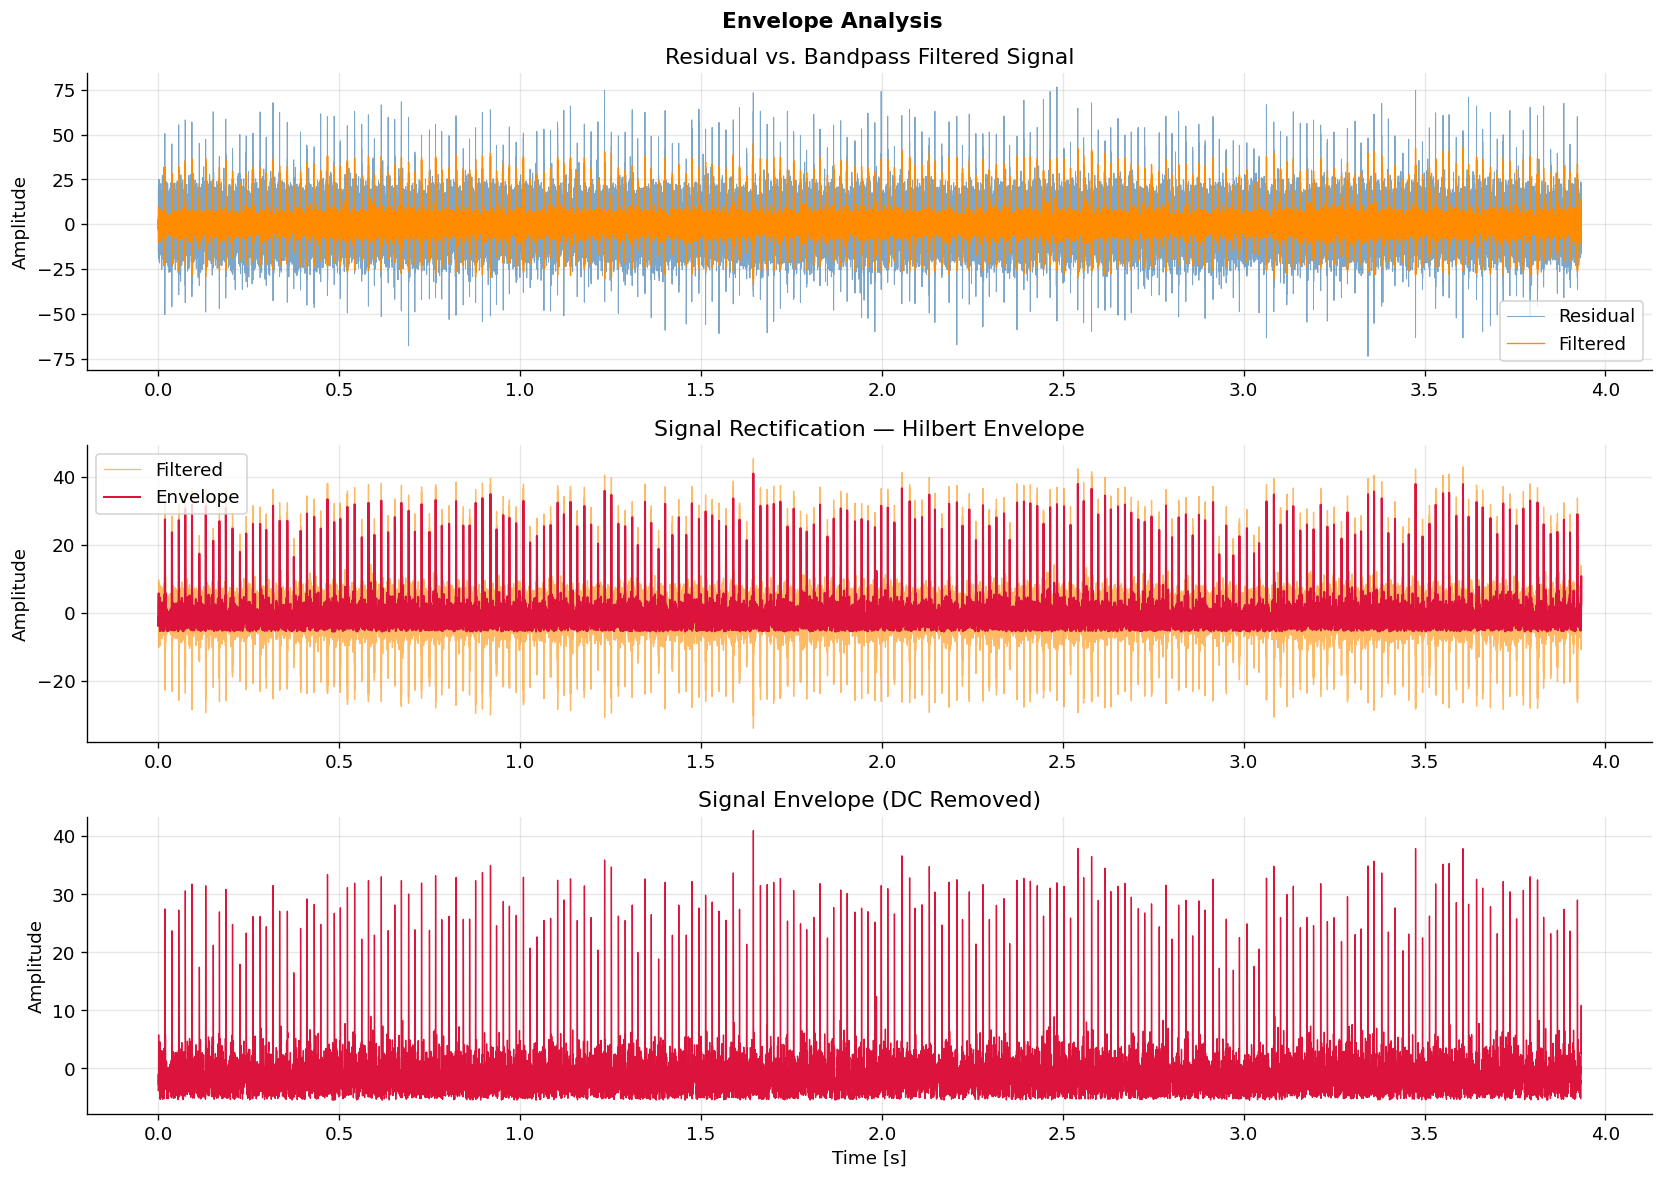

In [20]:
# ── Run envelope analysis ─────────────────────────────────────────────────────
x_filtered, envelope = envelope_analysis(
    x_residual, fs_vib, PASSBAND_LOW, PASSBAND_HIGH
)
freqs_ses, ses = compute_ses(envelope, fs_vib)

t_res = np.arange(len(x_residual)) / fs_vib

# ── Plot: filtering & envelope ────────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(t_res, x_residual, color='steelblue',  lw=0.6, alpha=0.7, label='Residual')
axes[0].plot(t_res, x_filtered, color='darkorange',  lw=0.8, label='Filtered')
axes[0].set_title('Residual vs. Bandpass Filtered Signal')
axes[0].set_ylabel('Amplitude')
axes[0].legend()

axes[1].plot(t_res, x_filtered, color='darkorange', lw=0.8, alpha=0.6, label='Filtered')
axes[1].plot(t_res, envelope,   color='crimson',    lw=1.2, label='Envelope')
axes[1].set_title('Signal Rectification — Hilbert Envelope')
axes[1].set_ylabel('Amplitude')
axes[1].legend()

axes[2].plot(t_res, envelope, color='crimson', lw=0.8)
axes[2].set_title('Signal Envelope (DC Removed)')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time [s]')

plt.suptitle('Envelope Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

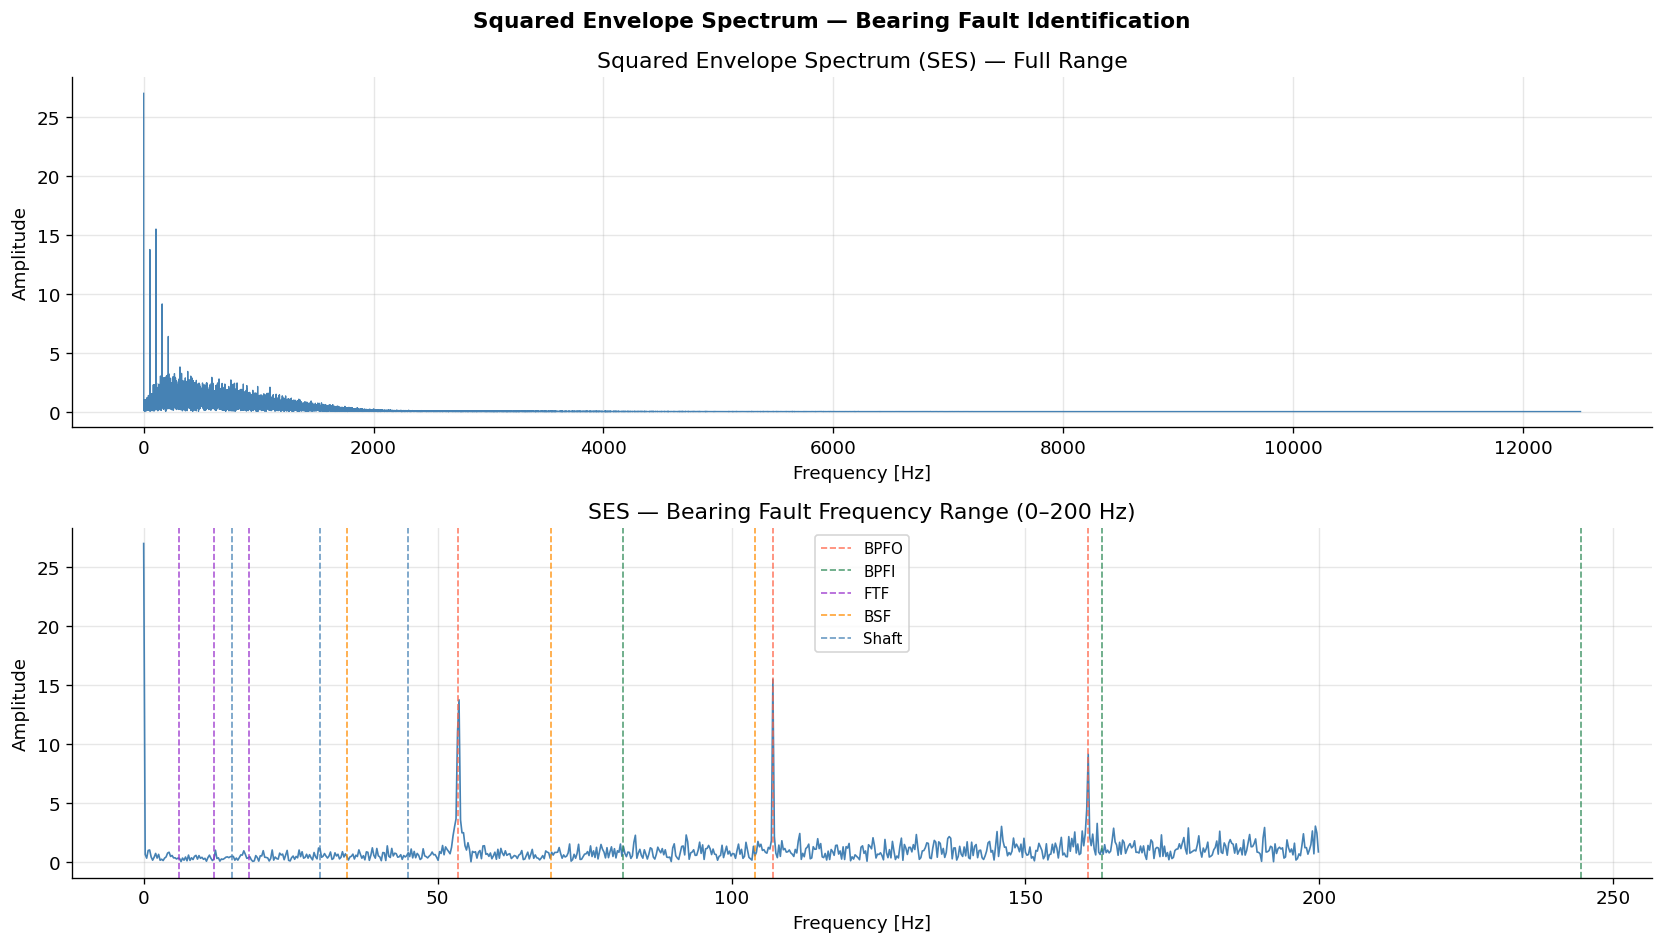

In [21]:
# ── Squared Envelope Spectrum with fault frequency markers ────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full SES
axes[0].plot(freqs_ses, ses, color='steelblue', lw=0.8)
axes[0].set_title('Squared Envelope Spectrum (SES) — Full Range')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlabel('Frequency [Hz]')

# Zoomed: bearing fault frequency range
zoom_mask = freqs_ses <= 200
axes[1].plot(freqs_ses[zoom_mask], ses[zoom_mask], color='steelblue', lw=1.0)

# Add fault frequency markers
fault_freqs = {
    'BPFO': BPFO,
    'BPFI': BPFI,
    'FTF':  FTF,
    'BSF':  BSF,
    'Shaft': fr
}
colors_fault = ['tomato', 'seagreen', 'darkorchid', 'darkorange', 'steelblue']
for (label, freq), col in zip(fault_freqs.items(), colors_fault):
    for harmonic in range(1, 4):
        lbl = label if harmonic == 1 else f'_{harmonic}x'
        axes[1].axvline(freq * harmonic, color=col, ls='--', lw=1.0,
                        alpha=0.8, label=lbl if harmonic == 1 else None)

axes[1].set_title('SES — Bearing Fault Frequency Range (0–200 Hz)')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].legend(fontsize=9)

plt.suptitle('Squared Envelope Spectrum — Bearing Fault Identification', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Envelope Analysis Results

The SES cleanly reveals the **BPFO at 53.52 Hz** and its harmonics, confirming an outer race fault on the SKF 6206 bearing.

No GMF content is present in the SES — confirming that TSA successfully separated the gear and bearing components before envelope analysis.

**Process summary:**

| Step | Purpose | Output |
|---|---|---|
| TSA | Separate deterministic gear content | `x_tsa`, `x_residual` |
| Spectral Kurtosis | Identify impulsive frequency band | Passband: 7–9 kHz |
| Butterworth filter | Isolate bearing impulse content | `x_filtered` |
| Hilbert transform | Demodulate envelope | `envelope` |
| SES | Identify fault repetition frequency | BPFO + harmonics |

---

## Summary

This notebook demonstrates a complete classical signal processing pipeline for bearing fault detection in a gearbox under constant shaft speed. All functions are custom implementations.

For the varying-speed case — where frequency smearing makes this approach insufficient — see **`02_varying_load_analysis.ipynb`**, which introduces Bayesian Geometry Compensation and Computed Order Tracking.

For a learning-based alternative to this pipeline using Hankel matrices and PCA, see **`03_learning_based_diagnostics.ipynb`**.